In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/Doodle Recognition/Dataset" "/content/Dataset"

Mounted at /gdrive


In [ ]:
# from google.colab import drive
# drive.flush_and_unmount()

**MODEL TRAINING**

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import glob
import os
import matplotlib.figure
from sklearn.model_selection import train_test_split
import pandas as pd

from keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Declare Variables
rows=4
cols=5
vfold_ratio=0.1, 
max_items_per_class=3000
img_size=64
batch_size=32
epochs=20

In [ ]:
all_files = glob.glob(os.path.join('/content/Dataset/PreprocessedData', '*.npy'))
all_files.sort()
len(all_files)

10

In [ ]:
#initialize variables 
x = np.empty([0,64,64,1])
y = np.empty([0])
class_names = []
#test_label=[]
#testx=np.empty([0,784])
    #load each data file 
for idx, file in enumerate(all_files):
    data = np.load(file)
    #test = data[0:max_items_per_class, :]
    data = data[0: max_items_per_class, :]
    labels = np.full(data.shape[0], idx)
    x = np.concatenate((x, data), axis=0)
    #testx= np.concatenate((testx, test), axis=0)
    y = np.append(y, labels)

    class_name, ext = os.path.splitext(os.path.basename(file))
    class_name=class_name.split('_')[-1].split('.')[0]
    class_names.append(class_name)
data = None
labels = None
    
    #randomize the dataset 
permutation = np.random.permutation(y.shape[0])
X_train = x[permutation, :]
y = y[permutation].astype(int)

X_train.shape


(30000, 64, 64, 1)

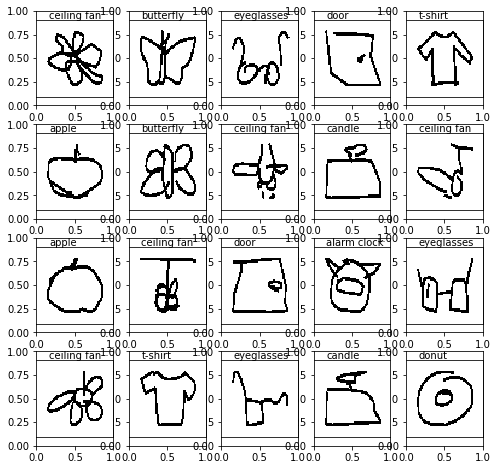

In [ ]:
fig, axes = plt.subplots(rows,cols, figsize=(8,8))
for i in list(range(0, min(len(X_train),(rows*cols)) )):    
    #fig = matplotlib.figure.Figure()
    a = fig.add_subplot(rows,cols,i+1)
    a.text(10., -1.5, f'{class_names[y[i]]}')
    imgplot = plt.imshow(X_train[i].reshape((64,64)), interpolation='nearest',cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])

In [ ]:
X_train /= 255.0

In [ ]:
class_names

['alarm clock',
 'apple',
 'birthday cake',
 'butterfly',
 'candle',
 'ceiling fan',
 'donut',
 'door',
 'eyeglasses',
 't-shirt']

In [ ]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(y, len(class_names))
y.shape

(30000, 10)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.20, random_state=0)

X_train=X_train.reshape(X_train.shape[0],64,64,1)
X_test=X_test.reshape(X_test.shape[0],64,64,1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(24000, 64, 64, 1)
(6000, 64, 64, 1)
(24000, 10)
(6000, 10)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

**MODEL**

In [ ]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=X_train.shape[1:], activation='relu'))
model.add(BatchNormalization(momentum = 0.8))
model.add(Conv2D(16, (3, 3), padding='same',input_shape=X_train.shape[1:], activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(BatchNormalization(momentum = 0.8))
model.add(Conv2D(16, (3, 3), padding='same', activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(BatchNormalization(momentum = 0.8))
model.add(Conv2D(16, (3, 3), padding='same', activation= 'relu'))
model.add(MaxPooling2D(pool_size =(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax')) 

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       1280      
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 16)        18448     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 64)       

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(0.001),loss ="categorical_crossentropy", metrics=['acc'])

In [ ]:
from keras.callbacks import ReduceLROnPlateau,EarlyStopping

erlystop = EarlyStopping(monitor='val_acc', min_delta=0, patience=7, verbose=0,mode='max', baseline=None)
cp_callback = ModelCheckpoint('/content/checkpoint', verbose=1, save_weights_only=True,save_freq='epoch',save_best_only=True,monitor='val_acc',mode='max')
rlrop = ReduceLROnPlateau(monitor='val_acc', patience=3,verbose=1,mode='max')

In [ ]:
modelHistory = model.fit(X_train,
      y_train,
      epochs=25,
      batch_size=batch_size,
      #validation_split=0.3, # 1000 images = batch_size * steps
      validation_data=(X_test,y_test),	
      callbacks=[cp_callback, rlrop, erlystop],
      verbose=1)

Epoch 1/25
748/750 [============================>.] - ETA: 0s - loss: 0.7746 - acc: 0.7561
Epoch 1: val_acc improved from -inf to 0.88700, saving model to /content/checkpoint
750/750 [==============================] - 23s 20ms/step - loss: 0.7735 - acc: 0.7563 - val_loss: 0.3598 - val_acc: 0.8870 - lr: 0.0010
Epoch 2/25
749/750 [============================>.] - ETA: 0s - loss: 0.3711 - acc: 0.8855
Epoch 2: val_acc improved from 0.88700 to 0.92600, saving model to /content/checkpoint
750/750 [==============================] - 14s 19ms/step - loss: 0.3709 - acc: 0.8856 - val_loss: 0.2367 - val_acc: 0.9260 - lr: 0.0010
Epoch 3/25
749/750 [============================>.] - ETA: 0s - loss: 0.3070 - acc: 0.9065
Epoch 3: val_acc improved from 0.92600 to 0.94533, saving model to /content/checkpoint
750/750 [==============================] - 15s 20ms/step - loss: 0.3070 - acc: 0.9065 - val_loss: 0.1946 - val_acc: 0.9453 - lr: 0.0010
Epoch 4/25
748/750 [============================>.] - ETA: 0s

In [ ]:
model.evaluate(X_train, y_train)

750/750 [==============================] - 6s 8ms/step - loss: 0.0214 - acc: 0.9937


[0.021388515830039978, 0.9937499761581421]

In [ ]:
model.evaluate(X_test, y_test)

188/188 [==============================] - 1s 8ms/step - loss: 0.1106 - acc: 0.9720


[0.110623799264431, 0.972000002861023]

In [ ]:
print(modelHistory.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


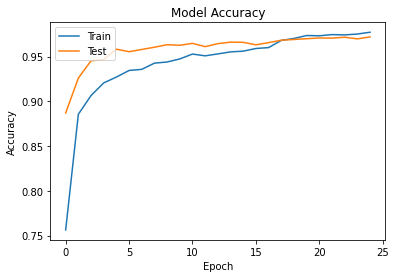

In [ ]:
plt.plot(modelHistory.history['acc'])
plt.plot(modelHistory.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

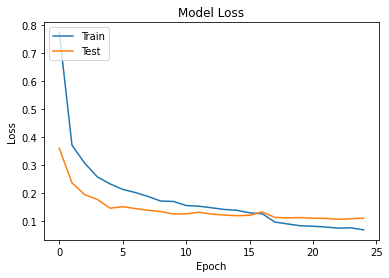

In [ ]:
plt.plot(modelHistory.history['loss'])
plt.plot(modelHistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

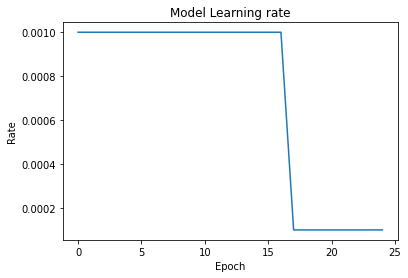

In [ ]:
plt.plot(modelHistory.history['lr'])
plt.title('Model Learning rate')
plt.ylabel('Rate')
plt.xlabel('Epoch')
plt.show()

In [ ]:
model.predict(X_test)

188/188 [==============================] - 1s 5ms/step


array([[1.00801911e-09, 9.92737670e-10, 7.77578848e-13, ...,
        9.89977891e-12, 2.39546694e-09, 4.44565496e-09],
       [3.18260609e-05, 1.06836205e-05, 9.92787302e-01, ...,
        3.19294986e-06, 2.43353634e-06, 1.65238774e-08],
       [9.52070128e-13, 9.29811889e-16, 1.25550585e-16, ...,
        1.40844190e-14, 1.40926411e-14, 1.00000000e+00],
       ...,
       [1.02671054e-08, 1.36311243e-07, 9.99907255e-01, ...,
        2.23129826e-09, 6.35695607e-10, 8.20232160e-10],
       [1.22648956e-07, 4.69473661e-11, 4.97482958e-11, ...,
        1.45026325e-13, 3.51369316e-08, 8.19883763e-15],
       [1.66087943e-07, 2.55703046e-11, 3.39181461e-11, ...,
        5.49880942e-13, 9.67044667e-09, 7.42034902e-16]], dtype=float32)

In [ ]:
model.save('doodle_best.h5')